# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `14`
* Students: `Kay Lächler, Roberto Chedraui, Viktor Crettenand, Francesco Gallo`

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

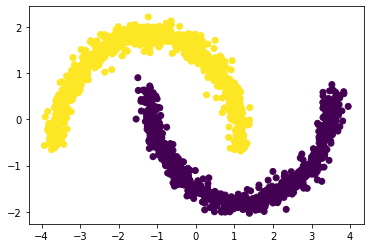

In [6]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [7]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(-(dist / (2 * sigma)) ** 2)
    adjacency = np.zeros(K.shape)
    # keep weights above threshold, corresponding to the shortest distances
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            if K[i,j] > epsilon:
                adjacency[i,j] = K[i,j]
    np.fill_diagonal(adjacency, 0)
    
    return adjacency

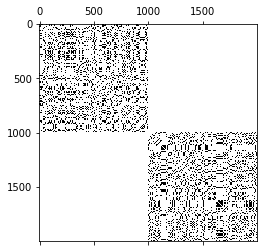

In [8]:
sigma = 1/5 * np.median(pdist(X, 'euclidean'))
adjacency = epsilon_similarity_graph(X, sigma=sigma, epsilon=0.5)
plt.spy(adjacency)
plt.show()

How do you choose `sigma`?

As the sigma is increased, the width of the kernel increases. The choice of sigma determines the steepness of the fall-off for higher distances. If we want to include high distances in the graph, we need to chose a large sigma. The choice of sigma heavily depends on the structure of the grap and can be approximated by a typical distance of the graph. Here the median of all the distances was chosen as a first guess. This initial guess was adjusted by multiplying it by some constant. The goal that was set out was to have a graph that is connected in a way that it is neither too hard nor too easy to cluster*

How do you choose the threshold `epsilon`?

*Having selected a suitable sigma, the adjacency matrix can be finetuned by choosing the threshold epsilon, which controls the sparsity of the final adjacency matrix. Epsilon can be chosen freely as to obtain the desired sparsity, however for weighted graphs it shouldn't be set too high as this results in a quasi-unweighted graph.*

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [9]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, axis = 1))
    L = D - adjacency
    
    if normalize:
        a = np.array(adjacency, dtype='float')
        a[np.sum(a, axis = 1)==0,0] = np.Inf
        Dn = np.diag(np.sum(a, axis = 1) ** (-0.5))
        L = Dn @ L @ Dn
    
    return L

In [10]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

*I'm using the solver 'eigh' contained in the 'linalg' package of numpy beacause it returns the eigenvalues and corresponding eigenvectors in ascending order, compared to the 'eig' function, which returns them unordered. The 'eigh' solver requires as input a symmetric matrix, which is the case for the Laplacian.*

In [11]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    return lamb, U

In [12]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

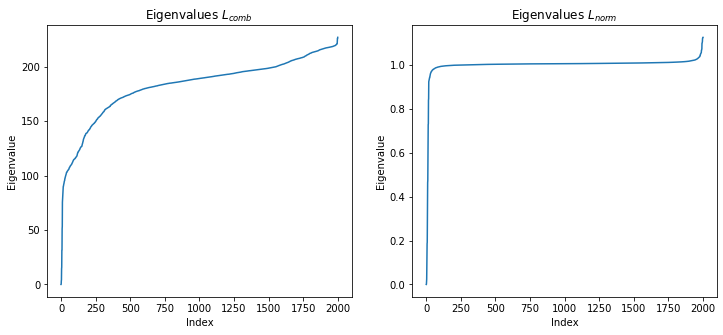

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

*Combinatorial Laplacian: The lowest eigenvalue $\lambda_0$ is zero and the corresponding eigenvector $u_0$ is a of the form $c1_N$ for some constant c.*

*Normalized Laplacian: The lowest eigenvalue $\lambda_0$ is zero and the corresponding eigenvector $u_0$ is a of the form $\frac{D^{1/2}1_N}{||D^{1/2}1_N||_2}$ for some constant c.*

When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

*The normalized Laplacian provides far better numerical stability than the combinatorial Laplacian because its eigenvalues are bounded between 0 and 2 and the eigenvectors are normalized by the volume of the graph. This insures that the values don't blow up during computation.*

#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [10]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    if threshold is None:
        threshold = 1e-9
    n_components = np.count_nonzero([lamb < threshold]) # include threshold for numerical inaccuracies
    return n_components

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

In [11]:
print(compute_number_connected_components(lamb_norm, threshold=None))

1


### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

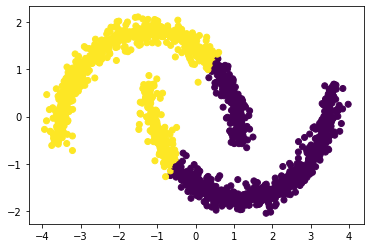

In [12]:
from sklearn.cluster import KMeans

# Your code here
Kmean = KMeans(n_clusters=2)
Kmean.fit(X)
y_pred =  Kmean.labels_
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

K-means cannot find a good solution to this problem. Why?

*Because the clusters are non-gaussian (not convex). The k-means algorithm cannot give the optimal solution for non-gaussian clusters.*

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [13]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        if normalize:
            self.clustering_method = "Normalized Spectral Clustering"
        else:
            self.clustering_method = "Unnormalized Spectral Clustering"
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        # Your code here
        if self.normalize:
            self.laplacian = compute_laplacian(adjacency, normalize=True)
            lamb, U = np.linalg.eigh(self.laplacian)
            self.e = lamb[:self.n_classes]
            self.U = U[:,:self.n_classes]
            row_norms = np.linalg.norm(self.U, axis=1)
            self.U = self.U / row_norms[:, np.newaxis]
            Kmean = KMeans(n_clusters=self.n_classes)
            Kmean.fit(self.U)
            y_pred = Kmean.labels_
        else:
            self.laplacian = compute_laplacian(adjacency, normalize=False)
            lamb, U = np.linalg.eigh(self.laplacian)
            self.e = lamb[:self.n_classes]
            self.U = U[:,:self.n_classes]
            Kmean = KMeans(n_clusters=self.n_classes)
            Kmean.fit(self.U)
            y_pred =  Kmean.labels_
            
        return y_pred

Connected components: 1


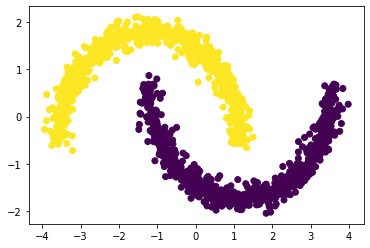

In [14]:
print("Connected components:", compute_number_connected_components(lamb_norm, threshold=1e-12))
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

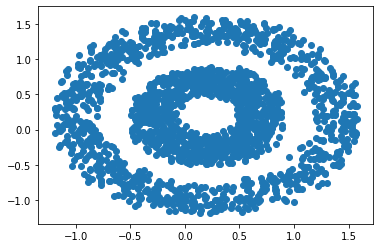

In [15]:
from pygsp.graphs import RandomRing

N=1000
G1=RandomRing(N)
G2=RandomRing(N)

X1 = G1.coords*0.5+np.random.random(G1.coords.shape)*0.4
X2=G2.coords*1.2+np.random.random(G1.coords.shape)*0.4

X=np.vstack((X1,X2))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

Run K-means:

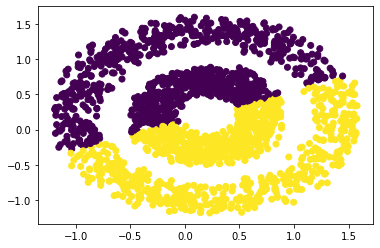

In [16]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(X)
y_pred =  Kmean.labels_
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

Connected components (norm): 2
Connected components (comb): 2


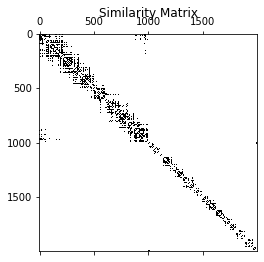

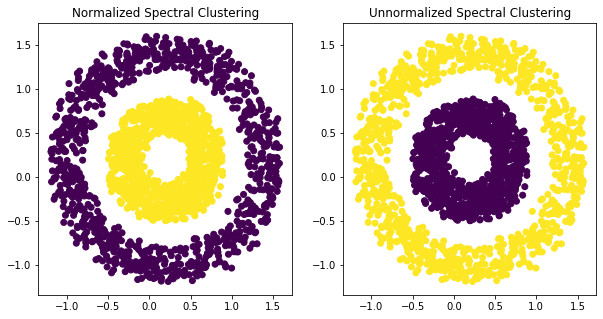

In [17]:
# Your code here
sigma = 1 / 5 * np.median(pdist(X, 'euclidean'))
adjacency = epsilon_similarity_graph(X, sigma=sigma, epsilon=0.8)
plt.spy(adjacency)
plt.title('Similarity Matrix')

laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)
print("Connected components (norm):", compute_number_connected_components(lamb_norm, threshold=None))
print("Connected components (comb):", compute_number_connected_components(lamb_norm, threshold=None))

fig, axes = plt.subplots(1, 2, figsize=(10,5))

spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred_norm = spectral_clustering.fit_predict(adjacency)
axes[0].scatter(X[:, 0], X[:, 1], c=y_pred_norm)
axes[0].set_title(spectral_clustering.clustering_method)

spectral_clustering = SpectralClustering(n_classes=2, normalize=False)
y_pred_comb = spectral_clustering.fit_predict(adjacency)
axes[1].scatter(X[:, 0], X[:, 1], c=y_pred_comb)
axes[1].set_title(spectral_clustering.clustering_method)

plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

*The chosen dataset consists of two rings with some added noise, which form two non-gaussian clusters. As can be observed, the k-means clustering does a terrible job of isolating the two different clusters. However, both the normalized and the unnormalized spectral clustering algorithms work perfectly to identify the two different rings.*

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [18]:
from utils import load_mnist

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

*If we make a ranking of pairs of points that are the closest together (i.e. most similar) in the starting space, laplacian eigenmaps tries to keep that ranking invariant. I.e. similar points are embeded close together. The distance between points that are not similar at all is neither minimized nor maximized. In general the dimenionality reduction with Laplacian eigenmaps preseves local distances.*

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [19]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    adjacency = epsilon_similarity_graph(X, sigma, epsilon)
    plt.spy(adjacency)
    plt.show()
    L = compute_laplacian(adjacency, normalize)
    lamb, U = spectral_decomposition(L)
    comp = compute_number_connected_components(lamb, threshold=None)
    return U[:,comp:dim+comp]

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

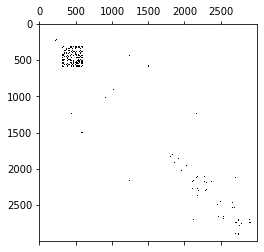

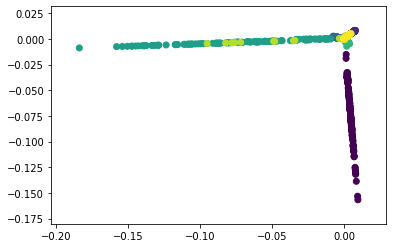

In [20]:
dim = 2
sigma = 1/3 * np.median(pdist(X_mnist, 'euclidean'))
Y = laplacian_eigenmaps(X_mnist, dim, sigma=sigma, epsilon=0.5, normalize=True)
plt.scatter(Y[:,0], Y[:,1], c=y_mnist)
plt.show()

Visualize MNIST in 3D:

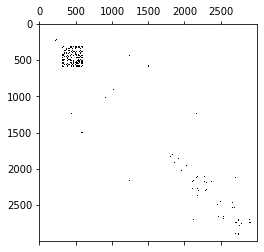

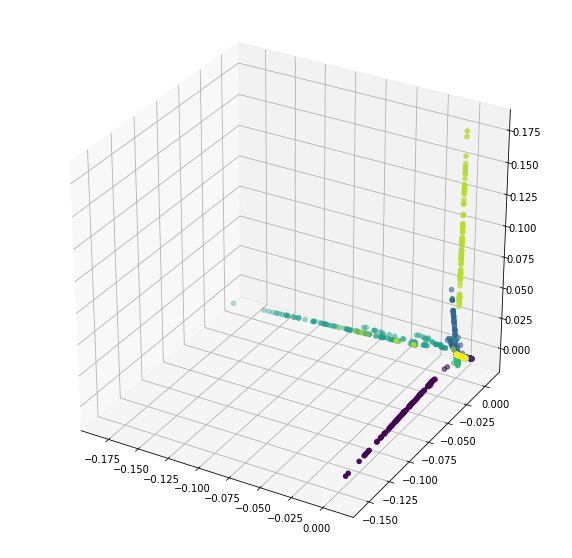

In [21]:
dim = 3
Y = laplacian_eigenmaps(X_mnist, dim, sigma=sigma, epsilon=0.5, normalize=True)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c=y_mnist)
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

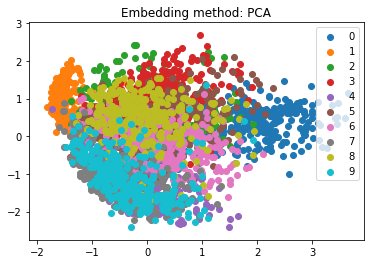

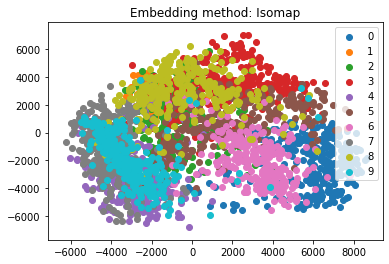

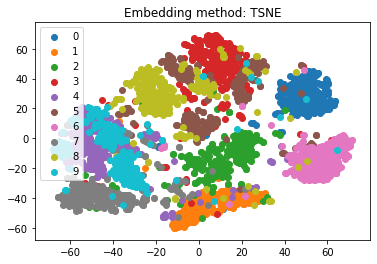

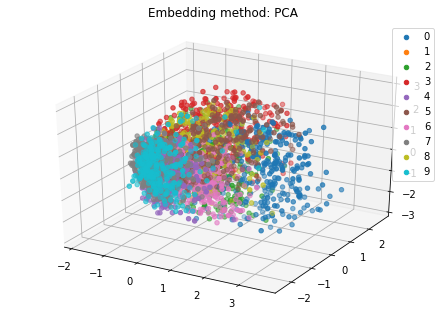

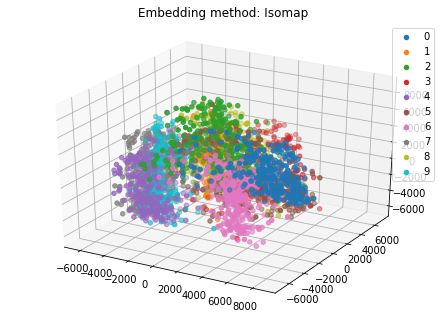

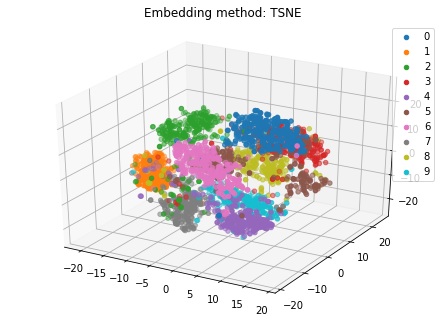

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

*PCA: Makes an orthogonal transformation of the basis in which the data is expressed in such a way that the first base vectors account for most of the variance in the data. Once this transformation is done, the components along the base vectors accounting for the least variance in the data are deleted.*

*Isomap: Estimates the geodesic distances (distance along the manifold) between two points by the distance of the shortest paths between the two points on the nearest neighbour graph. This estimation of distances allows to calculate a distance matrix that is then fed to the MDS algorithm that does dimensionality reduction by trying to leave distances between points unchanged*

*TSNE: Express each point in the starting space as a linear combination of the position of its neighbour (in reality a weight function is minimized which so what is done is not exactly a linear combination but something close to it). Points are then embedded in a lower dimentional space trying to preserve each points position relative to its neighbours. By position relative to its neighbour what is meant is that their position should as close as possible to the previous linear combination of its neighbours in the starting space.*

*Laplacian eigenmaps is clearly the worst performing method, this could be improved changing the similarity matrix. Points of some colors can't even bee seen probably because they are embedded in the same position as points of other classes. One is only able to distinguish about three to five clusters for two and three dimensions respectively. Both PCA and Isomap are allow to distinguish some of the clusters but are far from perfect. TSNE delivers the best result of the four proposed methods. It is able to distinguish nearly all the clusters even in two dimensions but there are some outlyers.*

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [23]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [24]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [25]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

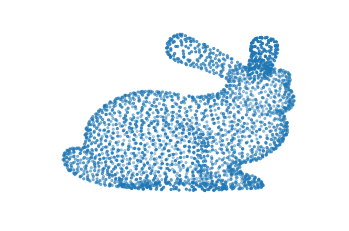

In [26]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [27]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

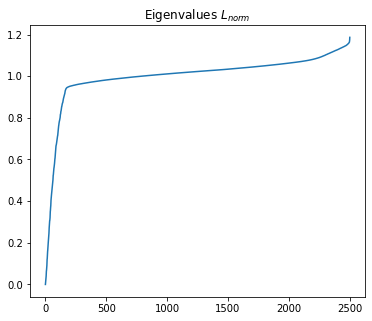

In [28]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

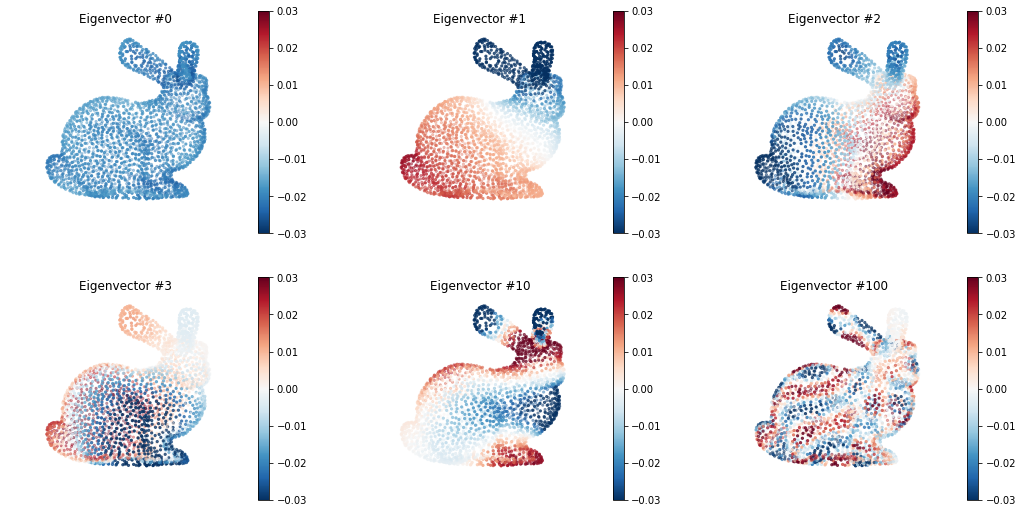

In [29]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

*The smaller the eigenvalue, the smoother the eigenvector. Eigenvectors that correspond to a large eigenvalue vary rapidly over the whole graph. The smoothness of a signal can be measured by the quantity $R = \sum_{t=1}^{n}(x(t+1)-x(t))^2$. The smaller R, the smoother the signal.*

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [30]:
def GFT(signal: np.ndarray):
    # Your code here
    return U.T @ signal
    
def iGFT(fourier_coefficients: np.ndarray):
    # Your code here
    return U @ fourier_coefficients

Now, let's create a graph signal:

C:\Users\kay-1\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


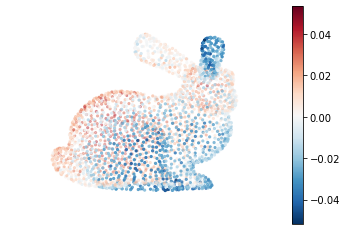

In [31]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

and plot its graph spectrum:

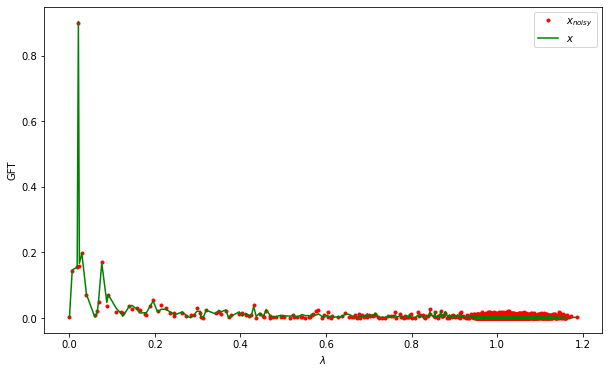

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])
plt.show()

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [33]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [34]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1 / (1 + alpha * lam)

Let's plot the spectral responses:

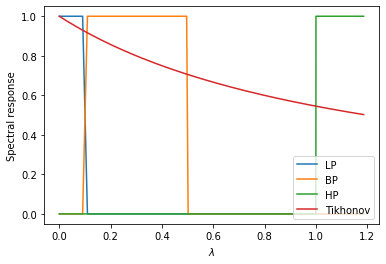

In [35]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.show()

Create a function to filter a signal given an ideal graph filter

In [36]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    # Your code here
    return iGFT(spectral_response * GFT(x))

Let us visualize the results:

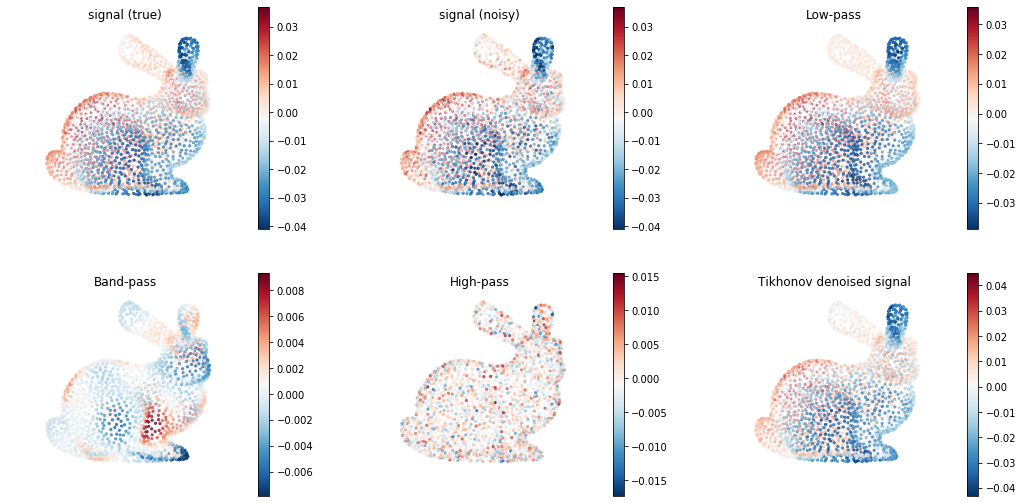

In [37]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

*I observed before, that the eigenvectors corresponding to a large eigenvalue represent high frequency components of the signal. The noise added to the signal mostly adds to the high frequencies of the original signal, which is why we get better results with a low-pass filter, which removes the eigenvectors corresponding to large eigenvalues in the spectral domain. However not all high frequencies are noise, this is why simply removing all high frequencies like the low pass filter does is too brutal because it removes a lot of the original signal along with the noise. The Tikhonov regularization is a low-pass filter which is less strict in the removing of high frequencies than the ideal low-pass filter and as such is preferable to remove the noise but keep the original signal intact.*

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [38]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    # Your code here
    a = np.vander(lam, N=order, increasing=True)
    x, res, rank, s = np.linalg.lstsq(a,spectral_response,rcond=None)
    return x

Implement a function to compute the frequency response of that filter.

In [39]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    a = np.vander(lam, N=len(coeff), increasing=True)
    return a @ coeff

Let us fit the Tikhonov ideal filter with several polynomials of different order.

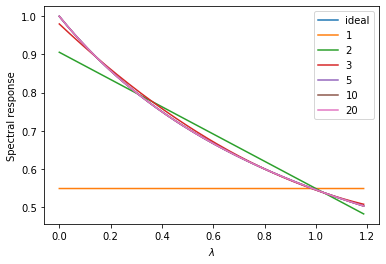

In [40]:
plt.plot(lam, ideal_tk)
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam))

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(["ideal"] + orders)
plt.show()

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [41]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    g = np.zeros(laplacian.shape)
    for i in range(len(coeff)):
        g += coeff[i] * np.linalg.matrix_power(laplacian, i)
    return g

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.

In [42]:
order = 5
coeff_tk = fit_polynomial(lam, order, ideal_tk)
g_tk = polynomial_graph_filter(coeff_tk, laplacian)

#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [43]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    # Your code here
    y = np.ones(laplacian.shape[1])
    for i in range(max_iter):
        y_new = -alpha * laplacian @ y + x
        y = y_new
        
    return y

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [44]:
x_tk_polynomial = g_tk @ x_noisy
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

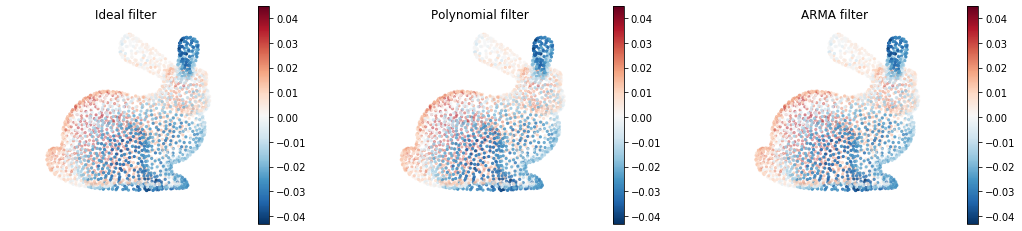

In [45]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [46]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [47]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

For this exercise we will use the normalized laplacian.

In [48]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [49]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [50]:
# Fit a logistic regression model
best = 0.0
best_c = 10
for c in np.linspace(10,600,60):
    lreg = LogisticRegression(C=c,solver='lbfgs',multi_class='auto',max_iter=1000).fit(train_features, train_labels)
    acc = lreg.score(val_features, val_labels)
    if acc > best:
        best = acc
        best_c = c

lreg = LogisticRegression(C=best_c,solver='lbfgs',multi_class='auto').fit(train_features, train_labels)
print(f'best_c: {best_c}')

C:\Users\kay-1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


best_c: 110.0


In [51]:
train_acc =  lreg.score(train_features, train_labels)
val_acc =  lreg.score(val_features, val_labels)
test_acc =  lreg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.5800 | Test accuracy 0.5330


#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

*The denoised signal will contain less high-frequency components.*

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [52]:
ideal_filter = np.ones((n_nodes,))
ideal_filter[lam > 0.25] = 0

Choose a filter order to approximate your filter using laplacian polynomials.

In [53]:
order = 5

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and its polynomial approximation.

Text(0, 0.5, 'Spectral response')

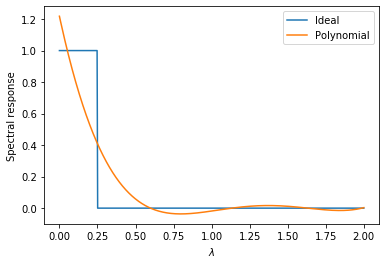

In [54]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Now, let's create the new features.

In [55]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [56]:
best = 0.0
best_c = 10
for c in np.linspace(10,600,60):
    lreg = LogisticRegression(C=c,solver='lbfgs',multi_class='auto',max_iter=1000).fit(train_features, train_labels)
    acc = lreg.score(val_features, val_labels)
    if acc > best:
        best = acc
        best_c = c

lreg = LogisticRegression(C=best_c,solver='lbfgs',multi_class='auto').fit(train_features, train_labels)
print(f'best_c: {best_c}')

C:\Users\kay-1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


best_c: 440.0


Evaluate your model.

In [57]:
train_acc =  lreg.score(train_features, train_labels)
val_acc =  lreg.score(val_features, val_labels)
test_acc =  lreg.score(test_features, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 0.9214 | Validation accuracy 0.8500 | Test accuracy 0.8230


#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [58]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [59]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [60]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

And train the classifier end to end.

In [61]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

C:\Users\kay-1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\kay-1\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.9459 | Val Accuracy 0.2667
Epoch 00001 | Time(s) nan | Train Loss 1.9221 | Val Accuracy 0.2533
Epoch 00002 | Time(s) nan | Train Loss 1.8533 | Val Accuracy 0.2467
Epoch 00003 | Time(s) 0.0708 | Train Loss 1.7058 | Val Accuracy 0.2700
Epoch 00004 | Time(s) 0.0663 | Train Loss 1.4878 | Val Accuracy 0.2900
Epoch 00005 | Time(s) 0.0638 | Train Loss 1.3438 | Val Accuracy 0.2967
Epoch 00006 | Time(s) 0.0648 | Train Loss 1.0504 | Val Accuracy 0.3067
Epoch 00007 | Time(s) 0.0644 | Train Loss 1.1285 | Val Accuracy 0.3167
Epoch 00008 | Time(s) 0.0665 | Train Loss 0.8329 | Val Accuracy 0.3200
Epoch 00009 | Time(s) 0.0645 | Train Loss 0.9067 | Val Accuracy 0.3167
Epoch 00010 | Time(s) 0.0648 | Train Loss 0.8401 | Val Accuracy 0.3133
Epoch 00011 | Time(s) 0.0637 | Train Loss 1.0514 | Val Accuracy 0.3133
Epoch 00012 | Time(s) 0.0629 | Train Loss 1.1378 | Val Accuracy 0.3300
Epoch 00013 | Time(s) 0.0631 | Train Loss 1.1666 | Val Accuracy 0.3200
Epoch 00014 | T

Epoch 00230 | Time(s) 0.0635 | Train Loss 0.0578 | Val Accuracy 0.7233
Epoch 00231 | Time(s) 0.0635 | Train Loss 0.1002 | Val Accuracy 0.7200
Epoch 00232 | Time(s) 0.0635 | Train Loss 0.0860 | Val Accuracy 0.7167
Epoch 00233 | Time(s) 0.0635 | Train Loss 0.0423 | Val Accuracy 0.7133
Epoch 00234 | Time(s) 0.0635 | Train Loss 0.1385 | Val Accuracy 0.7200
Epoch 00235 | Time(s) 0.0635 | Train Loss 0.1209 | Val Accuracy 0.7233
Epoch 00236 | Time(s) 0.0635 | Train Loss 0.0649 | Val Accuracy 0.7267
Epoch 00237 | Time(s) 0.0635 | Train Loss 0.0521 | Val Accuracy 0.7233
Epoch 00238 | Time(s) 0.0635 | Train Loss 0.0492 | Val Accuracy 0.7233
Epoch 00239 | Time(s) 0.0634 | Train Loss 0.0792 | Val Accuracy 0.7233
Epoch 00240 | Time(s) 0.0634 | Train Loss 0.0556 | Val Accuracy 0.7233
Epoch 00241 | Time(s) 0.0634 | Train Loss 0.0382 | Val Accuracy 0.7200
Epoch 00242 | Time(s) 0.0634 | Train Loss 0.0947 | Val Accuracy 0.7200
Epoch 00243 | Time(s) 0.0634 | Train Loss 0.0524 | Val Accuracy 0.7267
Epoch 

Epoch 00460 | Time(s) 0.0645 | Train Loss 0.0229 | Val Accuracy 0.7667
Epoch 00461 | Time(s) 0.0645 | Train Loss 0.0770 | Val Accuracy 0.7633
Epoch 00462 | Time(s) 0.0645 | Train Loss 0.0744 | Val Accuracy 0.7633
Epoch 00463 | Time(s) 0.0645 | Train Loss 0.0994 | Val Accuracy 0.7667
Epoch 00464 | Time(s) 0.0645 | Train Loss 0.0204 | Val Accuracy 0.7700
Epoch 00465 | Time(s) 0.0644 | Train Loss 0.0381 | Val Accuracy 0.7767
Epoch 00466 | Time(s) 0.0644 | Train Loss 0.0450 | Val Accuracy 0.7733
Epoch 00467 | Time(s) 0.0644 | Train Loss 0.0421 | Val Accuracy 0.7767
Epoch 00468 | Time(s) 0.0644 | Train Loss 0.0372 | Val Accuracy 0.7667
Epoch 00469 | Time(s) 0.0644 | Train Loss 0.0545 | Val Accuracy 0.7667
Epoch 00470 | Time(s) 0.0644 | Train Loss 0.0559 | Val Accuracy 0.7700
Epoch 00471 | Time(s) 0.0644 | Train Loss 0.0704 | Val Accuracy 0.7667
Epoch 00472 | Time(s) 0.0644 | Train Loss 0.1044 | Val Accuracy 0.7733
Epoch 00473 | Time(s) 0.0644 | Train Loss 0.0616 | Val Accuracy 0.7767
Epoch 

Epoch 00690 | Time(s) 0.0637 | Train Loss 0.0841 | Val Accuracy 0.7933
Epoch 00691 | Time(s) 0.0637 | Train Loss 0.0400 | Val Accuracy 0.8000
Epoch 00692 | Time(s) 0.0638 | Train Loss 0.0517 | Val Accuracy 0.7933
Epoch 00693 | Time(s) 0.0638 | Train Loss 0.0322 | Val Accuracy 0.7933
Epoch 00694 | Time(s) 0.0639 | Train Loss 0.0627 | Val Accuracy 0.7933
Epoch 00695 | Time(s) 0.0639 | Train Loss 0.0664 | Val Accuracy 0.7833
Epoch 00696 | Time(s) 0.0640 | Train Loss 0.0164 | Val Accuracy 0.7867
Epoch 00697 | Time(s) 0.0640 | Train Loss 0.0463 | Val Accuracy 0.7833
Epoch 00698 | Time(s) 0.0641 | Train Loss 0.0149 | Val Accuracy 0.7867
Epoch 00699 | Time(s) 0.0641 | Train Loss 0.0244 | Val Accuracy 0.7833
Epoch 00700 | Time(s) 0.0641 | Train Loss 0.0467 | Val Accuracy 0.7800
Epoch 00701 | Time(s) 0.0641 | Train Loss 0.0244 | Val Accuracy 0.7800
Epoch 00702 | Time(s) 0.0641 | Train Loss 0.1103 | Val Accuracy 0.7800
Epoch 00703 | Time(s) 0.0641 | Train Loss 0.0605 | Val Accuracy 0.7833
Epoch 

Epoch 00920 | Time(s) 0.0636 | Train Loss 0.0500 | Val Accuracy 0.8067
Epoch 00921 | Time(s) 0.0636 | Train Loss 0.0660 | Val Accuracy 0.8033
Epoch 00922 | Time(s) 0.0637 | Train Loss 0.0951 | Val Accuracy 0.7933
Epoch 00923 | Time(s) 0.0637 | Train Loss 0.0803 | Val Accuracy 0.7900
Epoch 00924 | Time(s) 0.0636 | Train Loss 0.0596 | Val Accuracy 0.7900
Epoch 00925 | Time(s) 0.0636 | Train Loss 0.0121 | Val Accuracy 0.7933
Epoch 00926 | Time(s) 0.0636 | Train Loss 0.0476 | Val Accuracy 0.7867
Epoch 00927 | Time(s) 0.0636 | Train Loss 0.0237 | Val Accuracy 0.7767
Epoch 00928 | Time(s) 0.0636 | Train Loss 0.0382 | Val Accuracy 0.7767
Epoch 00929 | Time(s) 0.0636 | Train Loss 0.0197 | Val Accuracy 0.7833
Epoch 00930 | Time(s) 0.0636 | Train Loss 0.0769 | Val Accuracy 0.7867
Epoch 00931 | Time(s) 0.0636 | Train Loss 0.0478 | Val Accuracy 0.7867
Epoch 00932 | Time(s) 0.0636 | Train Loss 0.1269 | Val Accuracy 0.7833
Epoch 00933 | Time(s) 0.0636 | Train Loss 0.0889 | Val Accuracy 0.7867
Epoch 

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [62]:
coeff_gcn = model.pol_weights.data.cpu().numpy()
print(coeff_gcn)

[-12.999396   16.839409   -1.9868376  -2.797177 ]


To interpret the model we can plot the frequency response of the learned filter.

Text(0, 0.5, 'Spectral response (db)')

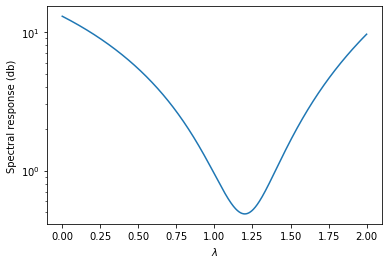

In [63]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [64]:
graph_gcn_filter =  polynomial_graph_filter(coeff_gcn, laplacian)

Let's extract the new features by filtering the data:

In [65]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [66]:
best = 0.0
best_c = 10
for c in np.linspace(10,600,60):
    lreg = LogisticRegression(C=c,solver='lbfgs',multi_class='auto',max_iter=1000).fit(train_features_gcn, train_labels)
    acc = lreg.score(val_features_gcn, val_labels)
    if acc > best:
        best = acc
        best_c = c

lreg = LogisticRegression(C=best_c,solver='lbfgs',multi_class='auto').fit(train_features_gcn, train_labels)
print(f'best_c: {best_c}')

best_c: 90.0


Finally, let's evaluate this model:

In [67]:
train_acc =  lreg.score(train_features_gcn, train_labels)
val_acc =  lreg.score(val_features_gcn, val_labels)
test_acc =  lreg.score(test_features_gcn, test_labels)

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

Train accuracy 1.0000 | Validation accuracy 0.8067 | Test accuracy 0.8010


The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

*When training with Pytorch, we use gradient descent to find the regularization parameter. In my method, a simple form of grid search is used to determine an approximation of the best regularization parameter. Surprisingly however, the test accuracy obtained with my method is slightly higher than that obtained with Pytorch.*